# I. Entendimento do negócio

## 1. Qual motivo do projeto?

A dengue é uma doença viral transmitida principalmente pelo mosquito Aedes aegypti e representa um desafio significativo para a saúde pública devido à sua rápida disseminação e impacto na população.

**1.1. Por que este projeto é importante?**
- Prever a propagação da doença permite que as autoridades de saúde implementem medidas preventivas e de controle de maneira mais eficaz, alocando recursos e intervenções precisamente nas áreas mais vulneráveis. 

**1.2. Como podemos fazer essa previsão?**
- Utilizando um modelo preditivo baseado em diversas informações relacionadas aos casos de dengue disponíveis no banco de dados. 

**1.3. O que buscamos?**
- O objetivo é prever o número de casos nos próximos 1500 dias, possibilitando uma resposta mais proativa e eficiente no combate à doença.

## 2. Como será realizado?

**2.1. Gerenciamento e organização do projeto:**
- Gerenciamento: framework [SCRUM](https://www.scrum.org/resources/what-scrum-module);
- Organização: framework [DM-CRISP](https://www.datascience-pm.com/crisp-dm-2/).

**2.2. Onde encontro os dados?**
- Competição [kaggle](https://www.kaggle.com/competitions/8-hackday-comunidadeds/overview);
- O dados tb encontram-se disponibilizados na pasta "data":
  - 'tb_fato.csv';
  - 'tb_casos_dengue.csv';
  - 'tb_agua_parada.csv';
  - 'tb_condicoes_climaticas.csv';
  - 'tb_falta_higiene.csv';
  - 'tb_conscientizacao.csv'.

**2.3. Quais as características que influenciam o número dos casos de dengue?**
- O dicionário de dados encontra-se [aqui]().

**2.4. Como será medido o desempenho?**

A métrica de desempenho escolhida é o [Root Mean Squared Error (RMSE)](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_RMSE.htm#PFUSU-GUID-FD9381A1-81E1-4F6D-8EC4-82A6CE2A6E74).

  **2.4.1. Por que usar o RSME?**
  - Ele ajuda a quantificar o desempenho do modelo em termos fáceis de entender. Por exemplo, se o RMSE for 5, isso significa que, em média, as previsões estão erradas por 5 unidades do valor real.

  **2.4.2. Como interpretar o RMSE?**
  - O RMSE nos dá uma ideia do erro absoluto médio das previsões, então:
    - Se o RMSE é baixo, significa que as previsões estão geralmente próximas dos valores reais. 
    - Se o RMSE é alto, significa que há um erro maior nas previsões.
  - O valor do RMSE está na mesma unidade dos valores que estamos tentando prever.

  **2.4.3. O que é o RMSE?**
  - É uma medida que nos ajuda a entender a precisão de um modelo de previsão;
  - O RMSE mede o quão perto ou longe as previsões do modelo estão dos valores reais;
  - Ele calcula a média dos erros ao quadrado entre os valores previstos e os valores reais e, em seguida, tira a raiz quadrada dessa média;
  - Fórmula: 

## 3. O que será entregue?

3.1. Uma página streamlit com as seguintes funcionalidades:
  - Previsão pontual dos casos de dengue;
  - Previsão em massa dos casos de dengue.

3.2. Um relatório de explanação contendo:
  - Análise descritiva;
  - Análise preditiva;
  - Análise diagnóstica;
  - Análise prescritiva.

## 4. Dicionários de dados

FEATURE	| DESCRIPTION
-- | --
Date | Data das informações
Conscientização da População | Nível de conscientização sobre a dengue
Condições de Moradia Precárias | Taxa de moradias precárias na área observada
Falta de Acesso a Serviços de Saúde | Taxa de moradores sem acesso a serviços de saúde
Migração de Pessoas de Áreas Endêmicas | Taxa de migração entre áreas
Transporte de Mercadorias em Áreas Urbanas | Porcentagem de veículos de transporte de cargas
Presença de mosquito | Quantidade de mosquitos observada
Casos de dengue | Total de número de casos observados no dia
Presença de Criadouros | Porcentagem da área com presença de mosquitos
Água Parada em Terrenos Baldios | Porcentagem da área com presença de água parada
Presença de Piscinas sem Manutenção | Número de piscinas sem manutenção observadas
Presença de Recipientes sem Tampas | Número de recipientes observados no dia
Precipitação | Água proveniente do vapor de água atmosférica depositada na superfície
Umidade | Relação entre a pressão parcial da água contida no ar e a pressão de vapor da água à temperatura do ar
Temperatura | Calor da atmosfera, medido em graus Celsius (ºC)
Falta de Coleta de Lixo | Taxa de coleta de lixo realizada
Área com Acúmulo de Entulho | Porcentagem da área com entulho
Falta de Controle de Pragas | Porcentagem da área observada sem controle de pragas
Taxa de Tratamento de Esgoto | Porcentagem de esgoto não tratado na área observada
Status | 'parcialmente conscientizada', 'indisponivel', 'desconscientizada', 'conscientizada', '<>'
Id | Identificador único do registro

# II. Entendimento dos dados

## 0. IMPORTS

### 0.1. Importing libraries

In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import inflection
import math
import datetime
from unidecode import unidecode

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Model Selection and Validation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing for Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder

# Models
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor # Baseline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model Deployment
import pickle

# Configure sklearn to output DataFrames: Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output='pandas')

### 0.2. Helper functions

In [2]:
# DATA DESCRIPTION ---------------------------------------------------------------------------------------------------------------

def data_description(data):

    # 1. Data Dimensions
    print('*' * 20 + ' DATA DIMENSIONS ' + '*' * 20)
    print('Quantidade de linhas: {:,}'.format(data.shape[0]))
    print('Quantidade de colunas: {:,}'.format(data.shape[1]))
    print()

    # 2. Data Types
    print('*' * 20 + ' DATA TYPES ' + '*' * 25)
    print(data.dtypes)
    print()

    # 3. Check NA's
    print('*' * 20 + ' CHECK NAs ' + '*' * 26)
    print(data.isna().sum())
    print()

    # 4. Check duplicated
    print('*' * 20 + ' CHECK DUPLICATED ' + '*' * 19)
    print('Quantidade de registros duplicados: {:,}'.format(data.duplicated().sum()))

# DATA WRANGLING -----------------------------------------------------------------------------------------------

def rename_columns(cols):
    cols = list(map(lambda x: inflection.titleize(x), cols))
    cols = list(map(lambda x: x.replace(' ', ''), cols))
    cols = list(map(lambda x: unidecode(x), cols))
    cols = list(map(lambda x: inflection.underscore(x), cols))
    return cols

# Classifica por nível de proliferação
def definir_proliferacao(semana):
    # Baseado na identificação de 3 grupos muito definidos dentro da relação presenca_do_mosquito x semana_do_ano
    if 23 <= semana <= 39: return 'low'
    elif semana < 14 or semana > 48: return 'high'
    else: return 'medium'

# Identificar outliers
def outlier_identifier(data, col):
    high_outliers = 0  # Contador de outliers altos
    low_outliers = 0   # Contador de outliers baixos
    data['outlier'] = 'none'  # Inicializar a coluna 'outlier' com 'none'

    for week in data['semana_do_ano'].unique():
        Q1 = data.loc[data['semana_do_ano'] == week, col].quantile(0.25)
        Q3 = data.loc[data['semana_do_ano'] == week, col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        # Identificar outliers baixos
        low_outliers_mask = (data[col] < lower_bound) & (data['semana_do_ano'] == week)
        low_idx_outliers = data.loc[low_outliers_mask].index
        data.loc[low_idx_outliers, 'outlier'] = 'low'
        data.loc[low_idx_outliers, 'proliferacao'] = 'low_outlier'
        low_outliers += len(low_idx_outliers)
        
        # Identificar outliers altos
        high_outliers_mask = (data[col] > upper_bound) & (data['semana_do_ano'] == week)
        high_idx_outliers = data.loc[high_outliers_mask].index
        data.loc[high_idx_outliers, 'outlier'] = 'high'
        data.loc[high_idx_outliers, 'proliferacao'] = 'high_outlier'
        high_outliers += len(high_idx_outliers)

    return data, [low_outliers, high_outliers]

# Calcula a mediana por semana
def median_by_week(data, semana, col):
    median = data.loc[data['semana_do_ano'] == semana, col].median()
    idx_missing = data.loc[(data[col].isna()) & (data['semana_do_ano'] == semana), :].index
    return median, idx_missing

# Calcula a média por semana
def mean_by_week(data, semana, col):
    mean = data.loc[data['semana_do_ano'] == semana, col].mean()
    idx_missing = data.loc[(data[col].isna()) & (data['semana_do_ano'] == semana), :].index
    return mean, idx_missing

# DATA CLEANING ---------------------------------------------------------------------------------------------------------------

def data_cleaning(data_raw, float_columns, int_columns, categorical_columns):

    # 0. Faz uma cópia do dataframe
    data = data_raw.copy()

    # 1. Transformar 'indisponivel' em NA
    for col in float_columns:
        if 'indisponivel' in data[col].values:
            data[col] = data[col].replace('indisponivel', np.nan)

    # 2. Transformar '<>' em NA
    for col in categorical_columns:
        data[col] = data[col].replace({'<>': 'none', 'indisponivel': 'none'})
   
    # 3. Substituir ',' por '.' e Converter float_columns de object para float
    for col in float_columns:
        if data[col].astype(str).str.contains(',').any():
            data[col] = data[col].str.replace(',', '.', regex=False).astype(float)
   
    # 4. Converter date para o tipo datetime
    data['date'] = pd.to_datetime(data['date'])

    # 5. Converter int_columns e float_columns de object para numerico
    for col in (int_columns + float_columns):
        data[col] = pd.to_numeric(data[col], errors='coerce')  # coerce errors to NaN

    # 6. Incluir colunas de data
    data['mes'] = data['date'].dt.month
    data['semana_do_ano'] = data['date'].dt.isocalendar().week

    # 7. Selecionar os índices dos registros que contêm NAN's
    idx_nans = data[data.isna().any(axis=1)].index
    print("Quantidade NAN's nas colunas selecionadas: {:.2} %".format((len(idx_nans) * 100)/data.shape[0]))

    # 8. Preencher NA's int_columns
    for col in int_columns:
        for semana in data['semana_do_ano'].unique():
            median, idx_missing = median_by_week(data, semana, col)
            data.loc[idx_missing, col] = round(median)

    # 9. Preencher NA's float_columns por semana do ano
    for col in float_columns:
        for semana in data['semana_do_ano'].unique():
            median, idx_missing = median_by_week(data, semana, col)
            data.loc[idx_missing, col] = median

    # 8 e 9 Preencher NA's
    #data.fillna(0, inplace=True)

    # 10. Converter int_columns de object para int
    for col in int_columns:
        data[col] = data[col].astype(int)    

    return data, idx_nans

# FEATURE ENGINEERING ---------------------------------------------------------------------------------------------------------------

def feature_engineering(data_raw):
    # 0. Faz uma cópia do dataframe
    data = data_raw.copy()

    # 1. Classifica por nível de proliferação
    data['proliferacao'] = data['semana_do_ano'].apply(lambda x: definir_proliferacao(x))
    #data['proliferacao'] = data.apply(lambda x: definir_proliferacao(x['semana_do_ano'], x['outlier']), axis=1)

    # 2. Incluir coluna que identifica outliers
    data, _ = outlier_identifier(data, 'presenca_do_mosquito')

    return data

# DATA PREPARATION -------------------------------------------------------------------------------------------

# Funções nomeadas globais para as transformações seno e cosseno
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

# Funções de transformação utilizando FunctionTransformer
def sin_transformer(period):
    return FunctionTransformer(func=sin_transform, kw_args={'period': period})

def cos_transformer(period):
    return FunctionTransformer(func=cos_transform, kw_args={'period': period})

# MODEL VALIDATION --------------------------------------------------------------------------------------------------------------------

# Medir a performance do modelo
def get_metrics(y_true, y_pred):
    dict_metrics  = {
        'R2': float(metrics.r2_score(y_true, y_pred)),
        'MAE': float(metrics.mean_absolute_error(y_true, y_pred)),
        'MAPE': float(metrics.mean_absolute_percentage_error(y_true, y_pred)),
        'RMSE': float(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    }
    return dict_metrics

### 0.3. Loading data

In [3]:
path = '../data/'

tb_fato                 = pd.read_csv(path + 'tb_fato.csv', low_memory=False, decimal='.')
tb_casos_dengue         = pd.read_csv(path + 'tb_casos_dengue.csv', low_memory=False, decimal='.')
tb_agua_parada          = pd.read_csv(path + 'tb_agua_parada.csv', low_memory=False, decimal='.')
tb_condicoes_climaticas = pd.read_csv(path + 'tb_condicoes_climaticas.csv', low_memory=False, decimal='.')
tb_falta_higiene        = pd.read_csv(path + 'tb_falta_higiene.csv', low_memory=False, decimal='.')
tb_conscientizacao      = pd.read_csv(path + 'tb_conscientizacao.csv', low_memory=False, decimal='.')

#### 0.3.1 Unir tabelas

In [4]:
# Unir tabelas
df_raw = pd.merge(tb_fato, tb_casos_dengue, how='left', on='Date', suffixes=('_fato', '_casos'))
df_raw = df_raw.merge(tb_agua_parada, how='left', on='Date', suffixes=('', '_agua'))
df_raw = df_raw.merge(tb_condicoes_climaticas, how='left', on='Date', suffixes=('', '_cli'))
df_raw = df_raw.merge(tb_falta_higiene, how='left', on='Date', suffixes=('', '_hig'))
df_raw = df_raw.merge(tb_conscientizacao, how='left', left_on='conscientização da população', right_on='id', suffixes=('', '_consc'))

#### 0.3.2. Separar o arquivo de teste

In [5]:
# Separar o arquivo de teste (os últimos 1500 dias, onde os casos de dengue estão faltando)
df_teste_raw = df_raw.loc[df_raw['Casos de dengue'].isna(), :].reset_index(drop=True)

# Remover os dados da amostra
casos_faltantes = df_raw.loc[df_raw['Casos de dengue'].isna(), :].index
df_raw = df_raw.drop(casos_faltantes, axis=0).reset_index(drop=True)

## 1. DATA DESCRIPTION

Impressão da descrição dos dados antes da limpeza (Data Cleaning)

In [6]:
# Descrição dos dados sem modificação
print('*' *9 + ' Descrição dos dados de treino | Antes ' + '*' *9)
data_description(df_raw)

********* Descrição dos dados de treino | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 24,028
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade       

In [7]:
# Descrição dos dados de teste sem modificação
print('*' *10 + ' Descrição dos dados de teste | Antes ' + '*' *9)
data_description(df_teste_raw)

********** Descrição dos dados de teste | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 3,000
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade        

## 2. DATA CLEANING

Vamos gerar dois dataframes limpos aqui, sendo:
1. Dataframe sem os NA's para que possamos avaliar a melhor forma de preenchimento ou a possibilidade de exclusão dos mesmos;
2. Dataframe completo e com os NA's preenchidos de acordo com a análise realizada.

Colunas selecionadas:
- Colunas selecionadas para análise = 'date', 'status', 'precipitacao', 'umidade', 'temperatura', 'presenca_do_mosquito', 'casos_de_dengue'
- Numéricas: 'casos_de_dengue', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura' 
- Categóricas: 'status' -
- Data: 'date'

In [8]:
int_columns = ['presenca_do_mosquito', 
               'conscientizacao_da_populacao',
               'presenca_de_recipientes_sem_tampas']

float_columns = ['precipitacao', 
                 'umidade',
                 'temperatura', 
                 'condicoes_de_moradia_precarias',
                 'falta_de_acesso_a_servicos_de_saude',
                 'migracao_de_pessoas_de_areas_endemicas',
                 'transporte_de_mercadorias_em_areas_urbanas', 
                 'outros',
                 'presenca_de_criadouros',
                 'agua_parada_em_terrenos_baldios',
                 'presenca_de_piscinas_sem_manutencao',
                 'falta_de_coleta_de_lixo',
                 'areas_com_acumulo_de_entulhos', 
                 'falta_de_controle_de_pragas',
                 'taxa_de_tratamento_de_esgoto']

categorical_columns = ['status']

TARGET_COLUMN = ['casos_de_dengue']


In [99]:
# Fazer uma cópia do dataframe original
df = df_raw.copy()

# 0. Renomear colunas
df.columns = rename_columns(df.columns)

# 0. Remover duplicatas
df = df.drop_duplicates().reset_index(drop=True)

# Selecionar colunas
numeric_columns = int_columns + float_columns
selected_columns = ['date'] + numeric_columns + categorical_columns

In [100]:
# Limpar dataframe completo 
df_cleaned, idx_nans = data_cleaning(df[TARGET_COLUMN + selected_columns], float_columns, TARGET_COLUMN + int_columns, categorical_columns)
df.isna().sum()

Quantidade NAN's nas colunas selecionadas: 1.6e+01 %


date                                           0
conscientizacao_da_populacao                   0
condicoes_de_moradia_precarias                62
falta_de_acesso_a_servicos_de_saude           91
migracao_de_pessoas_de_areas_endemicas        69
transporte_de_mercadorias_em_areas_urbanas    63
outros                                        56
presenca_do_mosquito                          53
casos_de_dengue                                0
presenca_de_criadouros                        74
agua_parada_em_terrenos_baldios               68
presenca_de_piscinas_sem_manutencao           59
presenca_de_recipientes_sem_tampas            67
precipitacao                                  53
umidade                                       65
temperatura                                   54
falta_de_coleta_de_lixo                       59
areas_com_acumulo_de_entulhos                 56
falta_de_controle_de_pragas                   69
taxa_de_tratamento_de_esgoto                  65
id                  

In [11]:
# Imprimir descrição dos dados depois da limpeza
print('*' *9 + ' Descrição dos dados | DEPOIS da limpeza ' + '*' *7)
data_description(df_cleaned)

********* Descrição dos dados | DEPOIS da limpeza *******
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 12,014
Quantidade de colunas: 23

******************** DATA TYPES *************************
casos_de_dengue                                        int64
date                                          datetime64[ns]
presenca_do_mosquito                                   int64
conscientizacao_da_populacao                           int64
presenca_de_recipientes_sem_tampas                     int64
precipitacao                                         float64
umidade                                              float64
temperatura                                          float64
condicoes_de_moradia_precarias                       float64
falta_de_acesso_a_servicos_de_saude                  float64
migracao_de_pessoas_de_areas_endemicas               float64
transporte_de_mercadorias_em_areas_urbanas           float64
outros                                

Na descrição dos dados, nota-se que:
1. Não há valores negativos;
2. Os casos de dengue e de presença do mosquito apresentam uma grande variabilidade em torno da média (desvio padrão);
3. Será necessário avaliar os outliers nos casos com desvio padrão muito grande (item 2).

In [58]:
df_cleaned[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
presenca_do_mosquito,12014.0,284349.729982,266875.901542,1023.000000,63482.500000,198877.500000,441652.750000,999530.000000
conscientizacao_da_populacao,12014.0,2.032296,0.680652,1.000000,2.000000,2.000000,2.000000,5.000000
presenca_de_recipientes_sem_tampas,12014.0,50394.004911,28579.505842,1007.000000,25719.500000,50452.500000,75187.000000,99969.000000
precipitacao,12014.0,84.719611,78.658596,0.009322,27.641255,54.219501,108.675195,299.966579
umidade,12014.0,65.983371,12.898242,40.005175,56.531511,65.381181,74.727422,94.995987
temperatura,12014.0,25.229748,5.303861,14.003989,21.564519,24.931640,28.577283,37.991244
condicoes_de_moradia_precarias,12014.0,0.402483,0.173115,0.100003,0.252370,0.403810,0.554822,0.699913
falta_de_acesso_a_servicos_de_saude,12014.0,0.274252,0.128966,0.050026,0.163701,0.274294,0.385844,0.499926
migracao_de_pessoas_de_areas_endemicas,12014.0,0.454004,0.202290,0.100138,0.279359,0.455939,0.631166,0.799965
transporte_de_mercadorias_em_areas_urbanas,12014.0,0.321136,0.156884,0.050011,0.184571,0.319895,0.456829,0.599966


## 3. FEATURE ENGINEERING

In [101]:
df_featured = feature_engineering(df_cleaned)

3.1. Incluir identificador de Outliers

- Identificar os outliers da variável dependente;
- Período selecionado: Por semanas do ano.

In [102]:
#df_featured, total_outliers = outlier_identifier(df_featured, 'presenca_do_mosquito')
print("Número de outliers baixos:", total_outliers[0])
print("Número de outliers altos:", total_outliers[1])
df_featured.head()

Número de outliers baixos: 0
Número de outliers altos: 25


,casos_de_dengue,date,presenca_do_mosquito,conscientizacao_da_populacao,presenca_de_recipientes_sem_tampas,precipitacao,umidade,temperatura,condicoes_de_moradia_precarias,falta_de_acesso_a_servicos_de_saude,...,presenca_de_piscinas_sem_manutencao,falta_de_coleta_de_lixo,areas_com_acumulo_de_entulhos,falta_de_controle_de_pragas,taxa_de_tratamento_de_esgoto,status,mes,semana_do_ano,proliferacao,outlier
0,270499,1987-01-01,874324,2,5501,168.814638,88.117339,37.113825,0.555259,0.281511,...,3057.0,0.246574,0.344882,0.373312,0.430001,parcialmente conscientizada,1,1,high,none
1,279224,1987-01-02,869290,2,63609,148.661492,61.232582,29.596003,0.481990,0.256312,...,1696.0,0.586354,0.298646,0.373297,0.430001,parcialmente conscientizada,1,1,high,none
2,221681,1987-01-03,880145,4,86840,267.744475,79.160989,26.844099,0.661297,0.054712,...,4996.0,0.105502,0.125506,0.324277,0.430001,none,1,1,high,none
3,76197,1987-01-04,295600,2,89673,162.011169,79.160989,29.870342,0.327871,0.317513,...,4502.0,0.552463,0.337130,0.428306,0.430001,parcialmente conscientizada,1,1,high,none
4,94530,1987-01-05,681702,2,55219,278.151803,77.434816,29.418697,0.246563,0.247595,...,4121.0,0.114032,0.426198,0.332206,0.430001,parcialmente conscientizada,1,2,high,none


## 4. EXPLORATORY DATA ANALYSIS (EDA)

Para uma compreensão mais profunda dos dados de casos de dengue, é essencial realizar uma análise detalhada dos outliers presentes. Esta análise nos permitirá:
1. Entender a Causa dos Outliers: Por que eles acontecem?
   - Identificar os fatores que estão causando valores atípicos nos dados. Podem ser erros de registro, eventos climáticos extremos, surtos localizados de dengue, entre outros;
   - Avaliar se esses outliers estão relacionados a variáveis específicas como precipitação, umidade, temperatura ou presença do mosquito.
2. Avaliar o Impacto dos Outliers na Previsão dos Casos de Dengue: Como eles afetam a previsão dos casos de dengue?
   - Analisar como os outliers influenciam os modelos de previsão e a precisão das previsões;
   - Verificar se os outliers distorcem as médias e outras estatísticas descritivas que são críticas para a modelagem;
   - Testar o desempenho dos modelos de previsão com e sem a presença dos outliers para quantificar seu impacto.
3. Determinar o Tratamento Adequado dos Outliers: O que fazer com eles?
   - Decidir se os outliers devem ser removidos, ajustados ou mantidos nos dados. Isso depende do contexto e da causa dos outliers;
   - Considerar métodos de imputação, transformação ou segregação dos outliers em análises separadas;
   - Desenvolver estratégias para lidar com os outliers em futuras coletas de dados para minimizar seu impacto.



<Figure size 1600x1200 with 0 Axes>

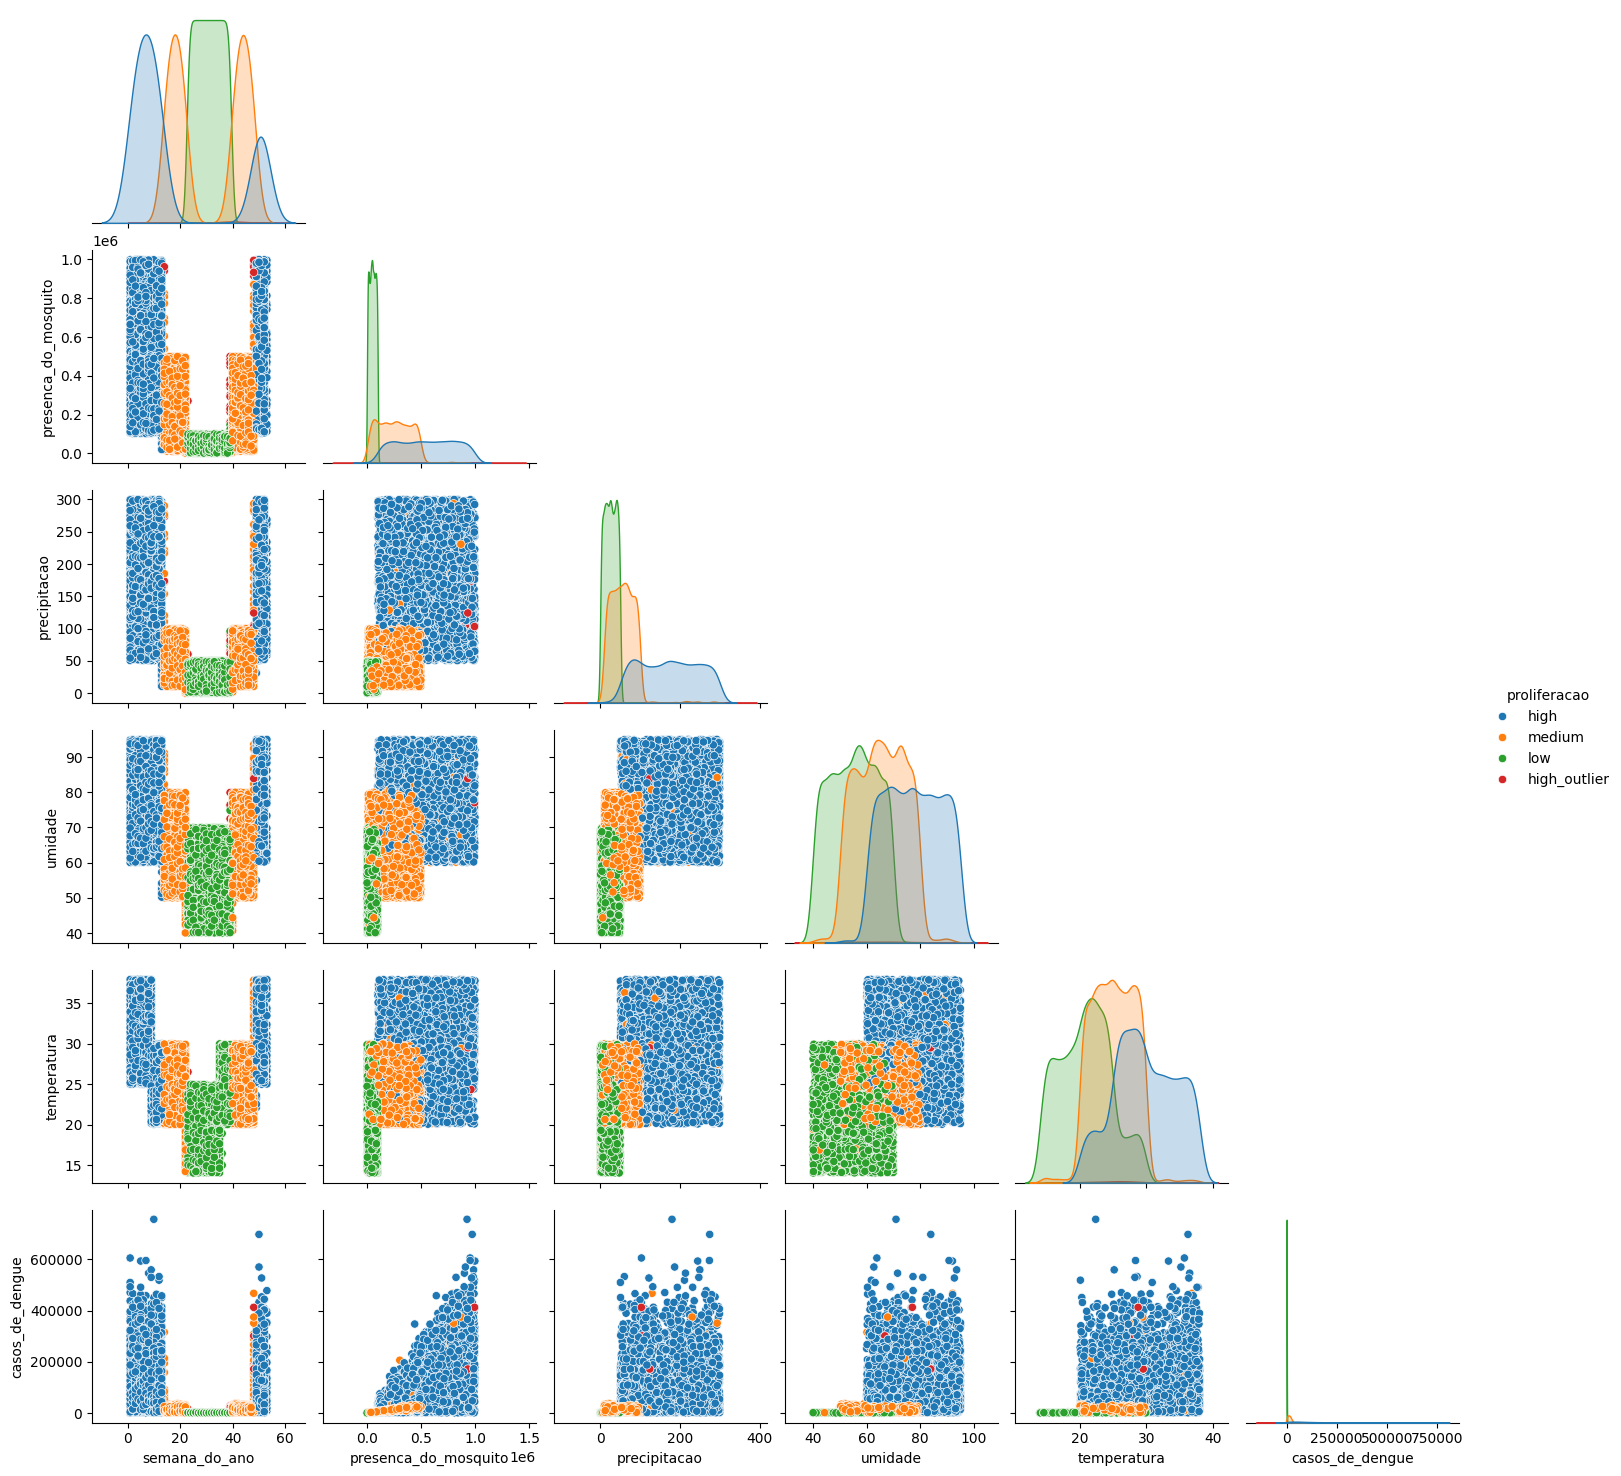

In [16]:
plt.figure(figsize=(16, 12))
sns.pairplot(df_featured[['semana_do_ano', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'proliferacao', 'casos_de_dengue']], hue='proliferacao', corner=True)
plt.show()

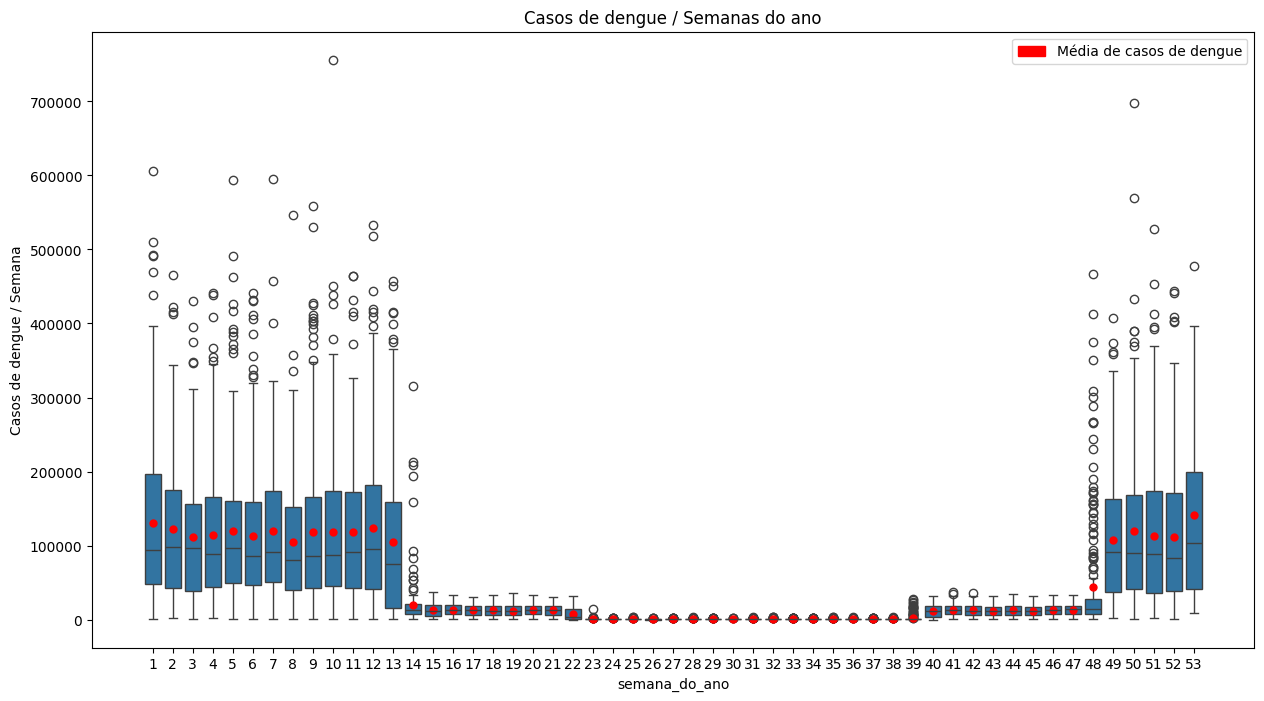

In [17]:
# Calcular a média de casos de dengue por semana do ano
mean_cases_by_week = df_featured.groupby('semana_do_ano')['casos_de_dengue'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df_featured, x='semana_do_ano', y='casos_de_dengue', ax=ax)
ax.set_title('Casos de dengue / Semanas do ano')
ax.set_ylabel('Casos de dengue / Semana')

# Adicionar a linha da média de casos de dengue por semana do ano
for week in mean_cases_by_week.index:
    ax.plot([week-1], [mean_cases_by_week[week]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de casos de dengue')
plt.legend(handles=[mean_patch])

plt.show()

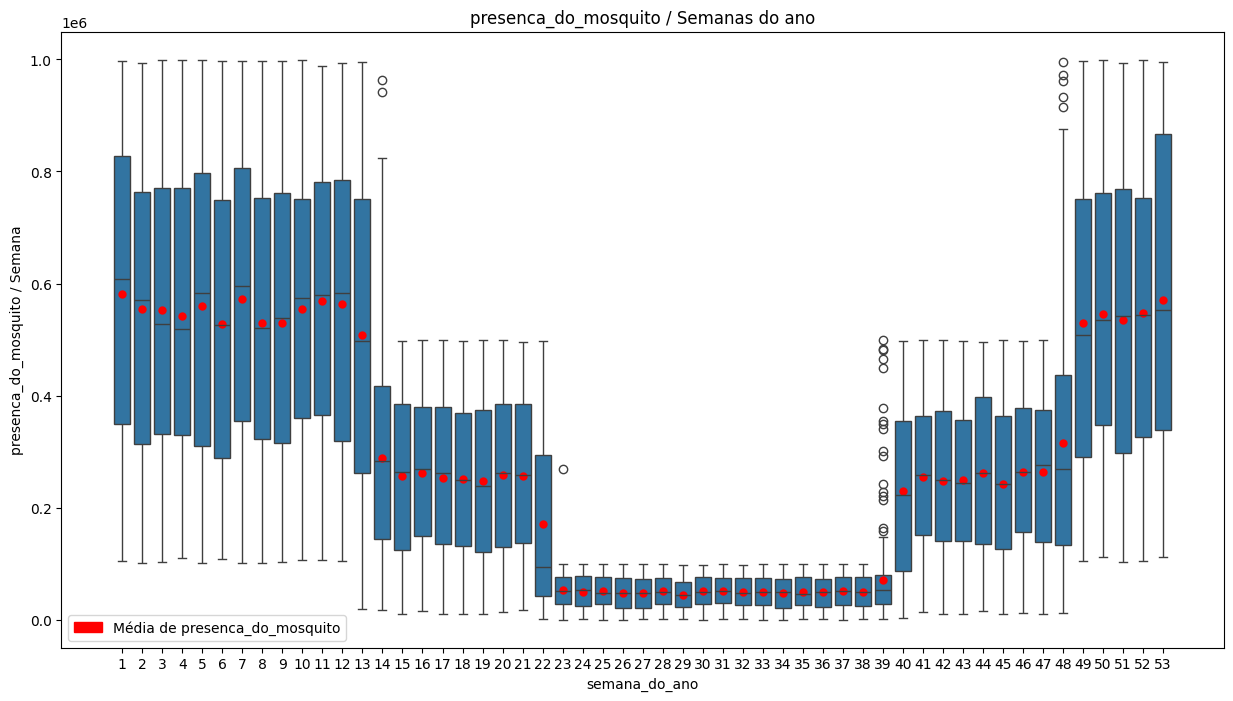

In [18]:
# Calcular a média de presenca_do_mosquito por semana do ano
mean_cases_by_week = df_featured.groupby('semana_do_ano')['presenca_do_mosquito'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df_featured, x='semana_do_ano', y='presenca_do_mosquito', ax=ax)
ax.set_title('presenca_do_mosquito / Semanas do ano')
ax.set_ylabel('presenca_do_mosquito / Semana')

# Adicionar a linha da média de presenca_do_mosquito por semana do ano
for week in mean_cases_by_week.index:
    ax.plot([week-1], [mean_cases_by_week[week]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de presenca_do_mosquito')
plt.legend(handles=[mean_patch])

plt.show()

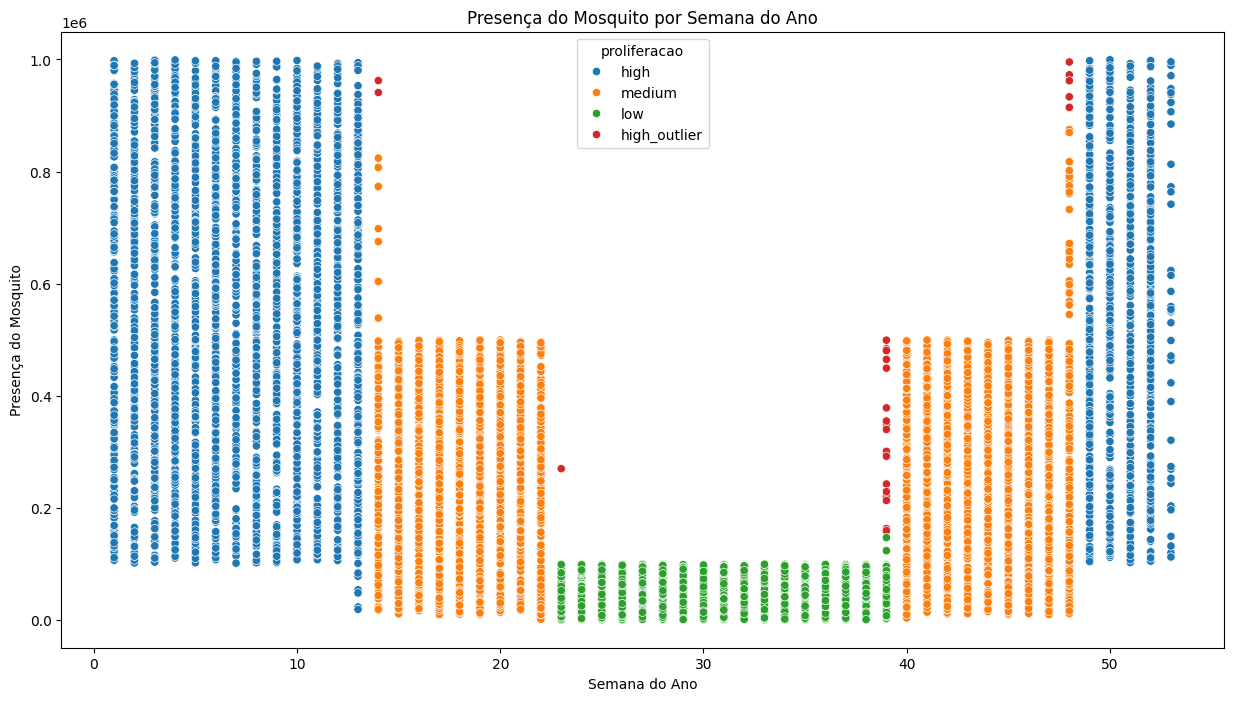

In [19]:
# Criação do scatterplot
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_featured, x='semana_do_ano', y='presenca_do_mosquito', hue='proliferacao')

# Adicionar título e rótulos aos eixos
plt.title('Presença do Mosquito por Semana do Ano')
plt.xlabel('Semana do Ano')
plt.ylabel('Presença do Mosquito')

# Mostrar o gráfico
plt.show()

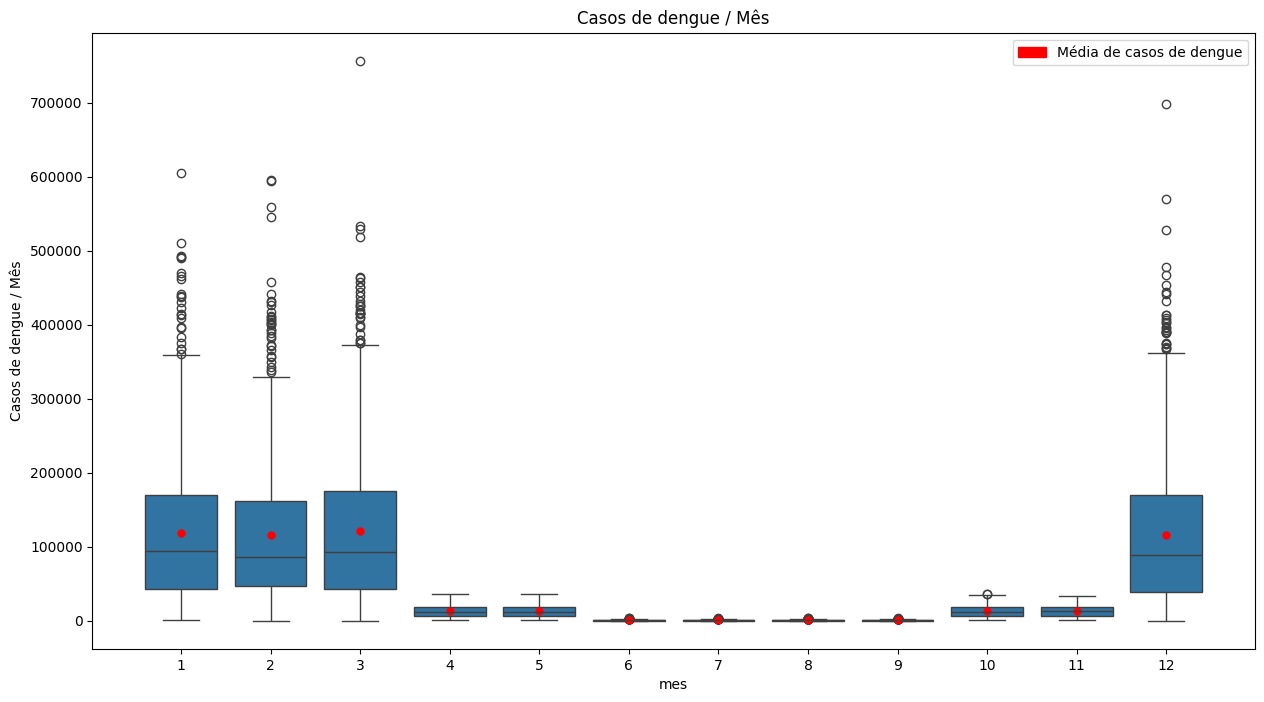

In [20]:
# Calcular a média de casos de dengue por mês
mean_cases = df_featured.groupby('mes')['casos_de_dengue'].mean()

# Plotar o boxplot
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df_featured, x='mes', y='casos_de_dengue', ax=ax)
ax.set_title('Casos de dengue / Mês')
ax.set_ylabel('Casos de dengue / Mês')

# Adicionar a linha da média de casos de dengue por mês
for month in mean_cases.index:
    ax.plot([month-1], [mean_cases[month]], marker='.', markersize=10, color='red')

# Adicionar legenda para a linha da média
import matplotlib.patches as mpatches
mean_patch = mpatches.Patch(color='red', label='Média de casos de dengue')
plt.legend(handles=[mean_patch])

plt.show()

### 4.1.  Análise Multivariada

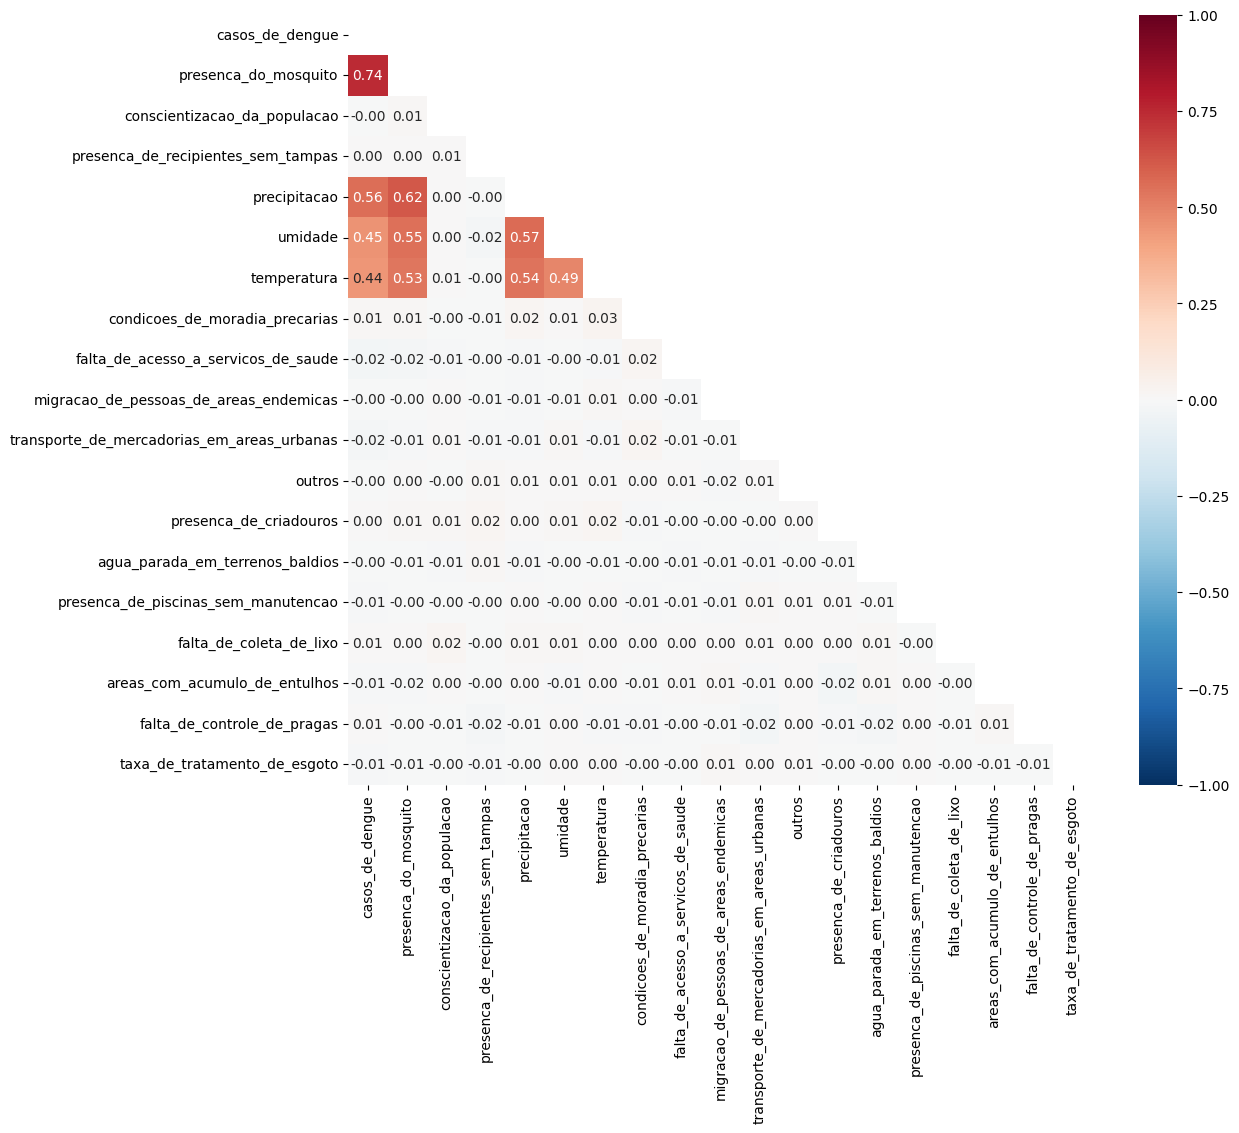

In [21]:
# Calcular a correlação
dfc = df_featured[TARGET_COLUMN + numeric_columns].corr()

# Criar a máscara para a parte superior da matriz de correlação
mask = np.zeros(dfc.shape, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))  # Ajuste o tamanho conforme necessário

# Criar o heatmap
sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask=mask)

# Mostrar o gráfico
plt.show()

<Axes: >

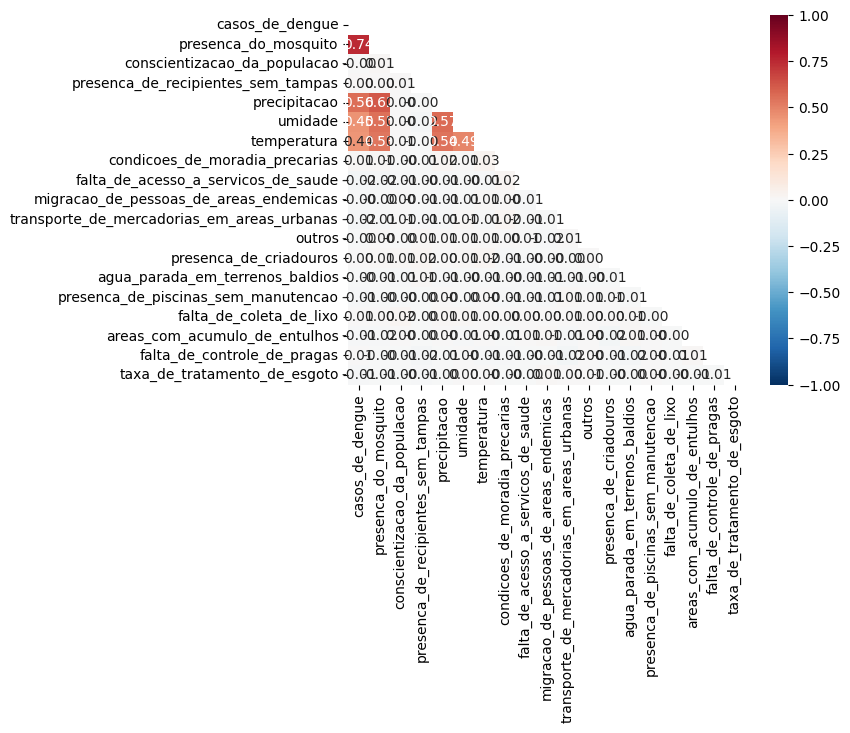

In [22]:
dfc = df_featured[TARGET_COLUMN + numeric_columns].corr()
mask  = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask=mask)

### 4.2. Análise Bivariada

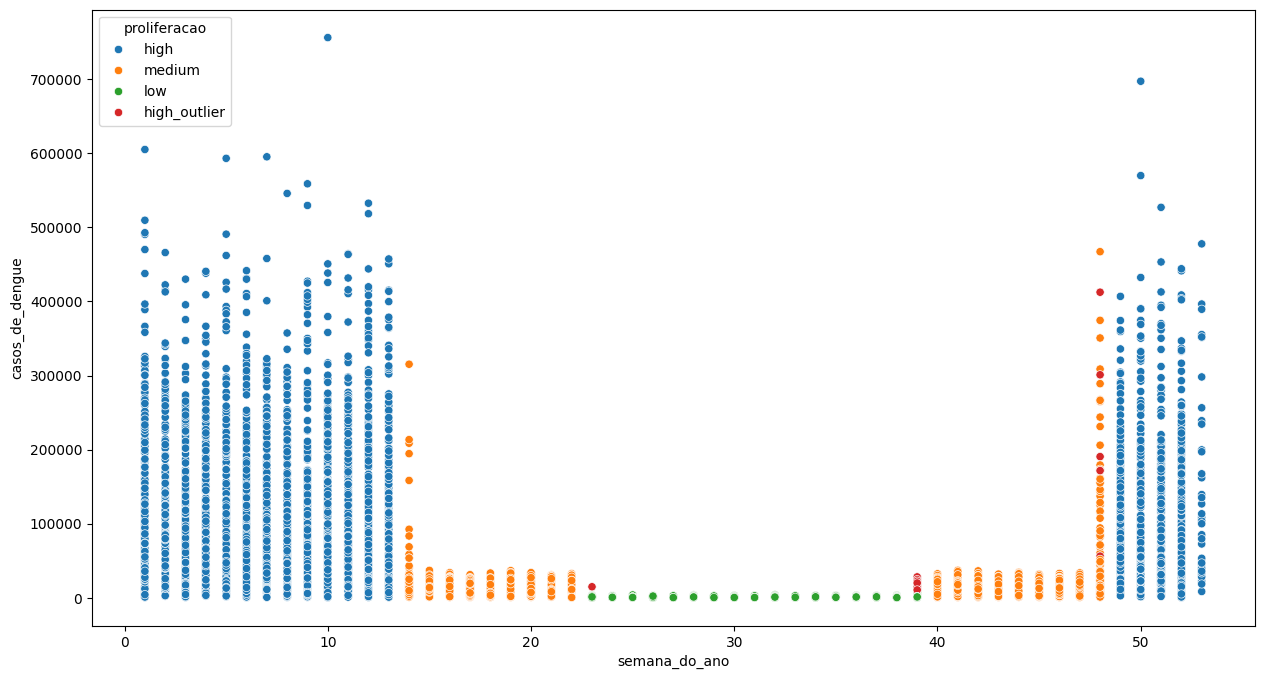

In [23]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='semana_do_ano', y='casos_de_dengue', data=df_featured, hue='proliferacao')
plt.show()

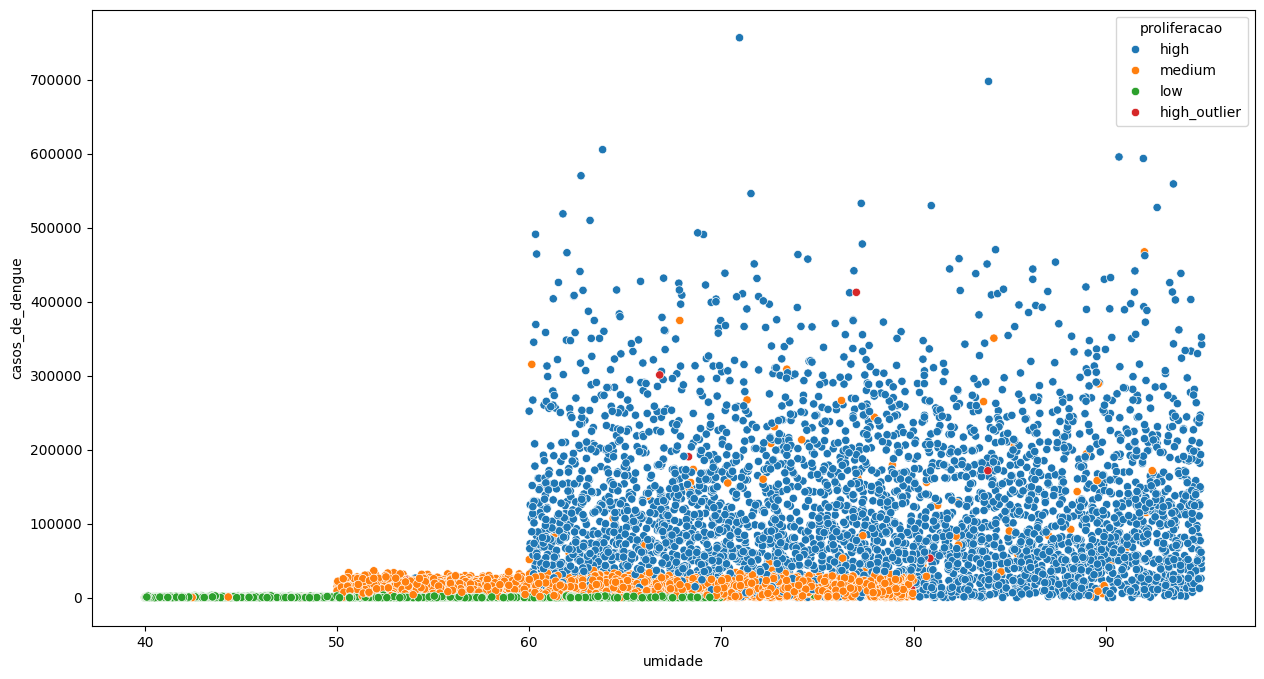

In [24]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='umidade', y='casos_de_dengue', data=df_featured, hue='proliferacao')
plt.show()

### 4.3. Análise Univariada

# III. Preparação dos dados

## 5. DATA PREPARATION

**Por que é importante?**

O aprendizado dos algoritmos de ML é facilitado com dados numéricos e na mesma escala.

**O que fazer?**
- Normalização: Diminuir o grau de importância das variáveis com maior range;
- Encoding: Transformar as variáveis categóricas em numéricas;
- Rescaling: Reescala para o intervalo entre 0 e 1;
- Transformation: [Transformação cíclica do time series](https://joaquinamatrodrigo.github.io/skforecast/0.8.1/faq/cyclical-features-time-series.html) (ex.: natureza cíclica dos meses, anos, semanas etc).

### 5.1. Separar arquivos de treino e validação

In [25]:
# Calcula a data de corte para o Split Dataframe Train / Test do Time Series
threshold_percentage = 10
days_qtd = round(df_featured.shape[0]*threshold_percentage/100)

max_date = df_featured['date'].max().strftime('%Y-%m-%d')

threshold_date = df_featured['date'].max() - datetime.timedelta(days=days_qtd)
threshold_date = threshold_date.strftime('%Y-%m-%d')
threshold_date

print('Dataframe max date: {}'.format(max_date))
print('Dataframe threshold date ({}%): {}'.format(threshold_percentage, threshold_date))

Dataframe max date: 2019-11-22
Dataframe threshold date (10%): 2016-08-08


In [26]:
numerical_features = numeric_columns
categorical_features = categorical_columns
cyclical_features = ['mes', 'semana_do_ano']

features = numerical_features + categorical_features + cyclical_features
TARGET = 'casos_de_dengue'

SEED = 42

X = df_featured[features]
y = df_featured[TARGET]

# Split Dataframe Train / Validation

# Training dataset 
X_train = df_featured[df_featured['date'] < threshold_date]
y_train = X_train['casos_de_dengue']

# Validation dataset
X_val = df_featured[df_featured['date'] >= threshold_date]
y_val = X_val['casos_de_dengue']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nValidation Min Date {}'.format(X_val['date'].min()))
print('Validation Max Date {}'.format(X_val['date'].max()))


Training Min Date 1987-01-01 00:00:00
Training Max Date 2016-08-07 00:00:00

Validation Min Date 2016-08-08 00:00:00
Validation Max Date 2019-11-22 00:00:00


### 5.3. Normalização do fenômeno

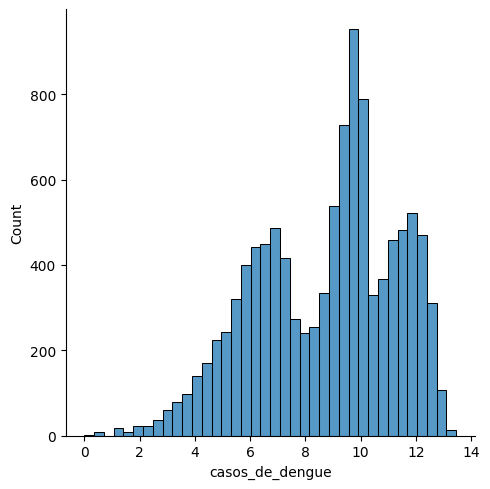

In [27]:
# Normalizar a variável dependente
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
sns.displot(y_train)

### 5.3. Demais transformações

In [28]:
# Rescalar variáveis Numéricas
numerical_transformer = MinMaxScaler()

# Encodar variáveis Categóricas
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Transformar variáveis cíclicas
cyclical_transformer = ColumnTransformer(transformers=[
    ('sin_mes', sin_transformer(12), ['mes']),
    ('cos_mes', cos_transformer(12), ['mes']),
    ('sin_semana', sin_transformer(52), ['semana_do_ano']),
    ('cos_semana', cos_transformer(52), ['semana_do_ano'])
], remainder='drop')

# Pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cyclical', cyclical_transformer, cyclical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [29]:
# Aplicando o pipeline ao seu conjunto de dados X_train
df_encoded = preprocessor.fit_transform(X_train)
df_encoded.head()

,num__presenca_do_mosquito,num__conscientizacao_da_populacao,num__presenca_de_recipientes_sem_tampas,num__precipitacao,num__umidade,num__temperatura,num__condicoes_de_moradia_precarias,num__falta_de_acesso_a_servicos_de_saude,num__migracao_de_pessoas_de_areas_endemicas,num__transporte_de_mercadorias_em_areas_urbanas,...,num__falta_de_controle_de_pragas,num__taxa_de_tratamento_de_esgoto,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__status_conscientizada,cat__status_desconscientizada,cat__status_none,cat__status_parcialmente conscientizada
0,0.874607,0.25,0.045411,0.562765,0.874913,0.963421,0.758874,0.514525,0.775698,0.980557,...,0.718607,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
1,0.869565,0.25,0.632586,0.495578,0.386017,0.650012,0.636740,0.458515,0.521675,0.101021,...,0.718573,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
2,0.880436,0.75,0.867333,0.892578,0.712043,0.535289,0.935631,0.010416,0.037537,0.864939,...,0.609618,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,1.0,0.0
3,0.295017,0.25,0.895960,0.540083,0.712043,0.661449,0.379836,0.594547,0.138264,0.934865,...,0.840840,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
4,0.681697,0.25,0.547806,0.927274,0.680653,0.642621,0.244303,0.439141,0.915985,0.306526,...,0.627243,0.0,0.5,0.866025,0.239316,0.970942,0.0,0.0,0.0,1.0


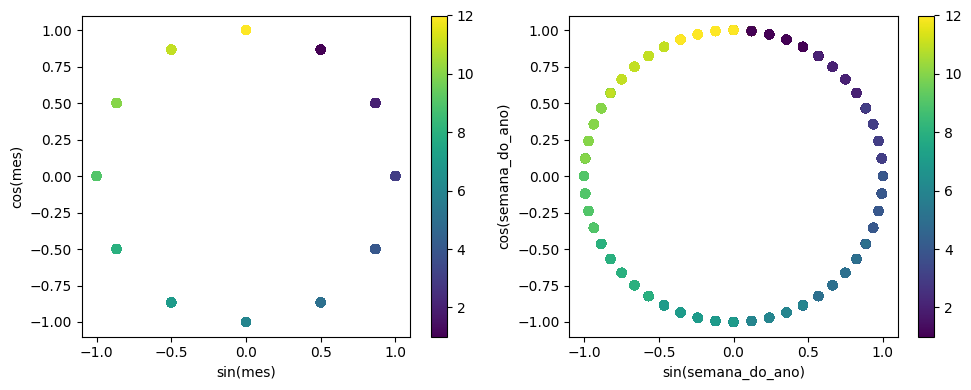

In [30]:
# Criação da figura e dos eixos para dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 linha, 2 colunas

# Primeiro gráfico
sp1 = ax1.scatter(
    df_encoded["cyclical__sin_mes__mes"],
    df_encoded["cyclical__cos_mes__mes"],
    c=X_train["mes"],
    cmap='viridis'
)
ax1.set(
    xlabel="sin(mes)",
    ylabel="cos(mes)",
)
fig.colorbar(sp1, ax=ax1)

# Segundo gráfico
sp2 = ax2.scatter(
    df_encoded["cyclical__sin_semana__semana_do_ano"],
    df_encoded["cyclical__cos_semana__semana_do_ano"],
    c=X_train["mes"],
    cmap='viridis'
)
ax2.set(
    xlabel="sin(semana_do_ano)",
    ylabel="cos(semana_do_ano)",
)
fig.colorbar(sp2, ax=ax2)

# Ajuste do layout
plt.tight_layout()
plt.show()

# IV. Modelagem

Pipeline:
- Data cleaning
- Feature Engineering
- Transformations (Encoder dos categóricos, escala dos numéricos)

## 6. MACHINE LEARNING MODELING

In [32]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(random_state=SEED),
        RidgeCV(),
        RandomForestRegressor(random_state=SEED),
        GradientBoostingRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED)
    ]
}

# grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='neg_root_mean_squared_error', verbose=1)

grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [33]:
# Pegar o melhor modelo
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'conscientizacao_da_populacao',
                                                   'presenca_de_recipientes_sem_tampas',
                                                   'precipitacao', 'umidade',
                                                   'temperatura',
                                                   'condicoes_de_moradia_precarias',
                                                   'falta_de_acesso_a_servicos_de_saude',
                                                   'migracao_de_pessoas_de_areas_endemicas',
                                                   'transporte_de_mercad...
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos_semana',
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000021ED925EC00>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['status'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [34]:
# Avaliar resultados
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('param_model').sort_values('rank_test_score')
cv_results.loc[:,~cv_results.columns.str.contains('split|time')]

,params,mean_test_score,std_test_score,rank_test_score
param_model,,,,
GradientBoostingRegressor(random_state=42),{'model': GradientBoostingRegressor(random_sta...,-0.851841,0.034072,1
RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},-0.872014,0.031136,2
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)","{'model': XGBRegressor(base_score=None, booste...",-0.916822,0.037195,3
LassoCV(random_state=42),{'model': LassoCV(random_state=42)},-1.137949,0.029839,4
LinearRegression(),{'model': LinearRegression()},-1.138829,0.030131,5
RidgeCV(),{'model': RidgeCV()},-1.138883,0.030112,6
DummyRegressor(),{'model': DummyRegressor()},-2.524926,0.010351,7


# V. Validação

## 7. HYPERPARAMETER FINE TUNING

### 7.1. GridSearchCV

In [37]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=SEED))
])

params = {
    'model__learning_rate': [0.1, 0.01, 1],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [250, 400, 800],
    'model__subsample': [1., .8]
}

#grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['presenca_do_mosquito',
                                                                          'conscientizacao_da_populacao',
                                                                          'presenca_de_recipientes_sem_tampas',
                                                                          'precipitacao',
                                                                          'umidade',
                                                                          'temperatura',
                                                                          'condicoes_de_moradia_precarias',
                                                                          'falta_de_acesso_a_servicos_de_saude',
                                                                          'migracao_de_pessoas_de_areas_ende...
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['status'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01, 1],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [250, 400, 800],
                         'model__subsample': [1.0, 0.8]},
             scoring='neg_root_mean_squared_error', verbose=2)

### 7.2. Validação

In [38]:
# Avaliar resultados do melhor modelo
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].head(5)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.847853,0.035481
2,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.848195,0.035294
3,0.01,4,800,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.848877,0.033737
4,0.01,5,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.849148,0.034031
5,0.01,5,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.849713,0.033780


In [39]:
# Pegar o melhor modelo com seus melhores parâmetros
model_pipeline = grid_model.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'conscientizacao_da_populacao',
                                                   'presenca_de_recipientes_sem_tampas',
                                                   'precipitacao', 'umidade',
                                                   'temperatura',
                                                   'condicoes_de_moradia_precarias',
                                                   'falta_de_acesso_a_servicos_de_saude',
                                                   'migracao_de_pessoas_de_areas_endemicas',
                                                   'transporte_de_mercad...
                                                                                  ('cos_semana',
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000021ED925EC00>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['status'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           n_estimators=400,
                                           random_state=42))])

In [40]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.5446414017602872,
 'MAE': 20127.39388387101,
 'MAPE': 2546980305393633.0,
 'RMSE': 51431.943770066275}

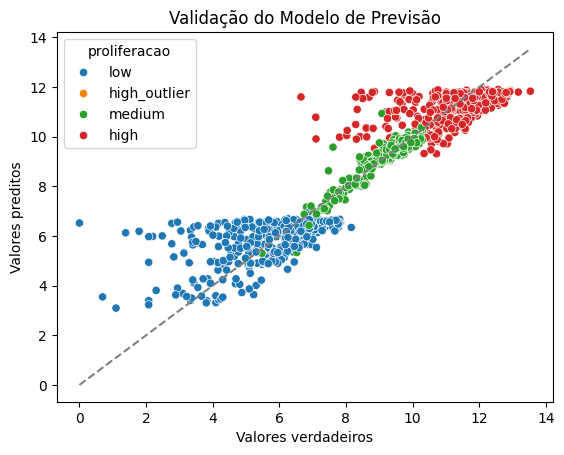

In [41]:
# Gráfico de dispersão com seaborn
sns.scatterplot(x=y_val, y=y_pred, hue=X_val.proliferacao)

# Adicionando linha de y = x (diagonal)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='gray')  # linha diagonal

# Configurações adicionais
plt.xlabel('Valores verdadeiros')
plt.ylabel('Valores preditos')
plt.title('Validação do Modelo de Previsão')

# Mostrar o gráfico
plt.show()

## 8. OPTIMIZATION

### 8.1. Feature Importance

- Data: Importância das features;
- Index: Nomes das features.

In [42]:
df_encoded.head()

,num__presenca_do_mosquito,num__conscientizacao_da_populacao,num__presenca_de_recipientes_sem_tampas,num__precipitacao,num__umidade,num__temperatura,num__condicoes_de_moradia_precarias,num__falta_de_acesso_a_servicos_de_saude,num__migracao_de_pessoas_de_areas_endemicas,num__transporte_de_mercadorias_em_areas_urbanas,...,num__falta_de_controle_de_pragas,num__taxa_de_tratamento_de_esgoto,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano,cat__status_conscientizada,cat__status_desconscientizada,cat__status_none,cat__status_parcialmente conscientizada
0,0.874607,0.25,0.045411,0.562765,0.874913,0.963421,0.758874,0.514525,0.775698,0.980557,...,0.718607,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
1,0.869565,0.25,0.632586,0.495578,0.386017,0.650012,0.636740,0.458515,0.521675,0.101021,...,0.718573,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
2,0.880436,0.75,0.867333,0.892578,0.712043,0.535289,0.935631,0.010416,0.037537,0.864939,...,0.609618,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,1.0,0.0
3,0.295017,0.25,0.895960,0.540083,0.712043,0.661449,0.379836,0.594547,0.138264,0.934865,...,0.840840,0.0,0.5,0.866025,0.120537,0.992709,0.0,0.0,0.0,1.0
4,0.681697,0.25,0.547806,0.927274,0.680653,0.642621,0.244303,0.439141,0.915985,0.306526,...,0.627243,0.0,0.5,0.866025,0.239316,0.970942,0.0,0.0,0.0,1.0


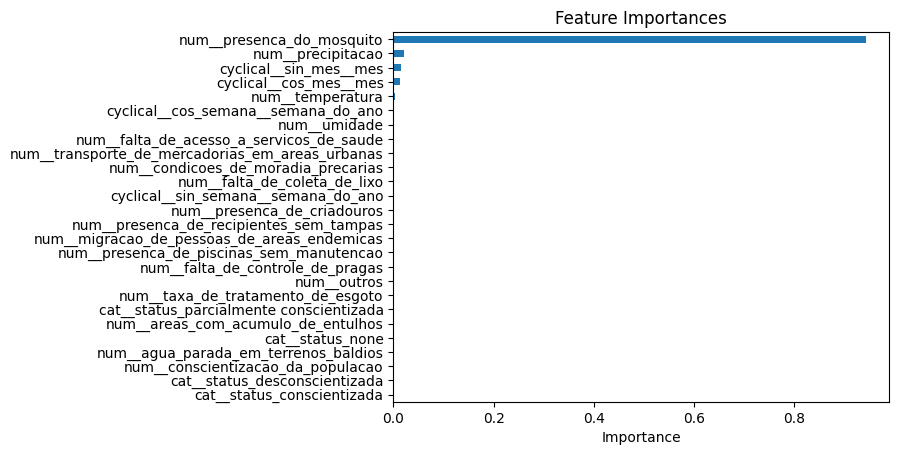

In [43]:
# Criação da série de importâncias
importances = pd.Series(
    index = df_encoded.columns,
    data = model_pipeline.named_steps['model'].feature_importances_
)

# Plotar e salvar a imagem
fig, ax = plt.subplots()
importances.sort_values().plot.barh(ax=ax)

plt.xlabel('Importance')
plt.title('Feature Importances')

# Salva a imagem e Exibe o gráfico
plt.savefig('../img/feature_importances.png', bbox_inches='tight') 
plt.show()

In [44]:
importances.sort_values(ascending=False)

num__presenca_do_mosquito                          9.421187e-01
num__precipitacao                                  2.078755e-02
cyclical__sin_mes__mes                             1.501274e-02
cyclical__cos_mes__mes                             1.269087e-02
num__temperatura                                   3.157814e-03
cyclical__cos_semana__semana_do_ano                1.963854e-03
num__umidade                                       6.364817e-04
num__falta_de_acesso_a_servicos_de_saude           5.573844e-04
num__transporte_de_mercadorias_em_areas_urbanas    4.901545e-04
num__condicoes_de_moradia_precarias                4.450704e-04
num__falta_de_coleta_de_lixo                       4.074239e-04
cyclical__sin_semana__semana_do_ano                3.429513e-04
num__presenca_de_criadouros                        2.332427e-04
num__presenca_de_recipientes_sem_tampas            1.907069e-04
num__migracao_de_pessoas_de_areas_endemicas        1.845640e-04
num__presenca_de_piscinas_sem_manutencao

### 8.2. Treino

In [103]:
numerical_features = ['presenca_do_mosquito'] + ['precipitacao', 'umidade', 'temperatura']
categorical_features = ['proliferacao']
cyclical_features = ['mes', 'semana_do_ano']

features = numerical_features + cyclical_features + categorical_features
TARGET = ['casos_de_dengue']

SEED = 42

df_featured = df_featured[['date'] + features + TARGET]

# Split Dataframe Train / Validation

# Training dataset 
X_train = df_featured[df_featured['date'] < threshold_date]
y_train = X_train['casos_de_dengue']

# Validation dataset
X_val = df_featured[df_featured['date'] >= threshold_date]
y_val = X_val['casos_de_dengue']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nValidation Min Date {}'.format(X_val['date'].min()))
print('Validation Max Date {}'.format(X_val['date'].max()))

Training Min Date 1987-01-01 00:00:00
Training Max Date 2016-08-07 00:00:00

Validation Min Date 2016-08-08 00:00:00
Validation Max Date 2019-11-22 00:00:00


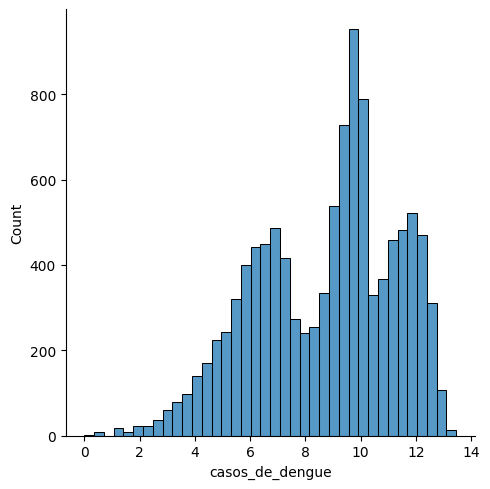

In [104]:
# Normalizar a variável dependente
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
sns.displot(y_train)

In [105]:
# Rescalar variáveis Numéricas
numerical_transformer = MinMaxScaler()

# Encodar variáveis Categóricas
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Transformar variáveis cíclicas
cyclical_transformer = ColumnTransformer(transformers=[
    ('sin_mes', sin_transformer(12), ['mes']),
    ('cos_mes', cos_transformer(12), ['mes']),
    ('sin_semana', sin_transformer(52), ['semana_do_ano']),
    ('cos_semana', cos_transformer(52), ['semana_do_ano'])
], remainder='drop')

# Pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
#    ('cat', categorical_transformer, categorical_features),
    ('cyclical', cyclical_transformer, cyclical_features)
])

# Aplicando o pipeline ao seu conjunto de dados X_train
df_encoded = preprocessor.fit_transform(X_train)
df_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano
0,0.874607,0.562765,0.874913,0.963421,0.5,0.866025,0.120537,0.992709
1,0.869565,0.495578,0.386017,0.650012,0.5,0.866025,0.120537,0.992709
2,0.880436,0.892578,0.712043,0.535289,0.5,0.866025,0.120537,0.992709
3,0.295017,0.540083,0.712043,0.661449,0.5,0.866025,0.120537,0.992709
4,0.681697,0.927274,0.680653,0.642621,0.5,0.866025,0.239316,0.970942


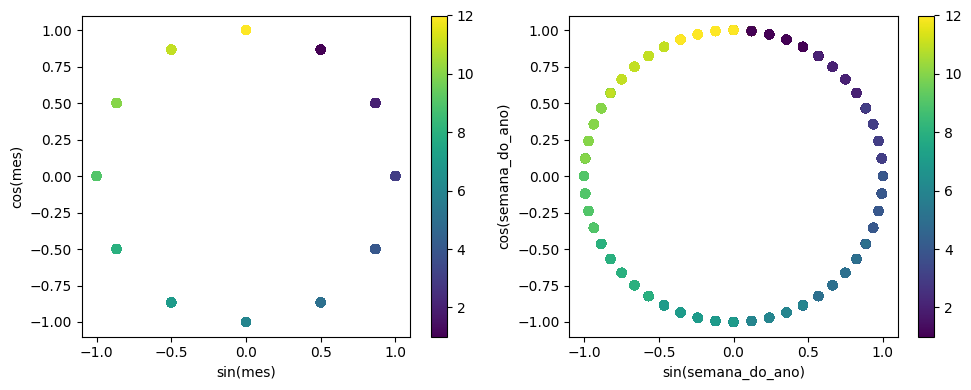

In [106]:
# Criação da figura e dos eixos para dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 linha, 2 colunas

# Primeiro gráfico
sp1 = ax1.scatter(
    df_encoded["cyclical__sin_mes__mes"],
    df_encoded["cyclical__cos_mes__mes"],
    c=X_train["mes"],
    cmap='viridis'
)
ax1.set(
    xlabel="sin(mes)",
    ylabel="cos(mes)",
)
fig.colorbar(sp1, ax=ax1)

# Segundo gráfico
sp2 = ax2.scatter(
    df_encoded["cyclical__sin_semana__semana_do_ano"],
    df_encoded["cyclical__cos_semana__semana_do_ano"],
    c=X_train["mes"],
    cmap='viridis'
)
ax2.set(
    xlabel="sin(semana_do_ano)",
    ylabel="cos(semana_do_ano)",
)
fig.colorbar(sp2, ax=ax2)

# Ajuste do layout
plt.tight_layout()
plt.show()


In [107]:
# MACHINE LEARNING MODELING
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(random_state=SEED),
        RidgeCV(),
        RandomForestRegressor(random_state=SEED),
        GradientBoostingRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='neg_root_mean_squared_error', verbose=1)

grid_model.fit(X_train, y_train);

#Pegar o melhor modelo
grid_model.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin_mes',
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                       kw_args={'period': 12}),
                                                                                   ['mes']),
                                                                                  ('cos_mes',
                                                                                   FunctionTransformer(func=<functi...
                                                                                                       kw_args={'period': 12}),
                                                                                   ['mes']),
                                                                                  ('sin_semana',
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos_semana',
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000021ED925EC00>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [108]:
# Avaliar resultados
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('param_model').sort_values('rank_test_score')
cv_results.loc[:,~cv_results.columns.str.contains('split|time')]

,params,mean_test_score,std_test_score,rank_test_score
param_model,,,,
GradientBoostingRegressor(random_state=42),{'model': GradientBoostingRegressor(random_sta...,-0.849166,0.035003,1
RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},-0.880517,0.025851,2
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)","{'model': XGBRegressor(base_score=None, booste...",-0.912631,0.031786,3
RidgeCV(),{'model': RidgeCV()},-1.137716,0.029950,4
LinearRegression(),{'model': LinearRegression()},-1.137720,0.029912,5
LassoCV(random_state=42),{'model': LassoCV(random_state=42)},-1.137791,0.029967,6
DummyRegressor(),{'model': DummyRegressor()},-2.524926,0.010351,7


In [109]:
# HYPERPARAMETER FINE TUNING
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=SEED))
])

params = {
    'model__learning_rate': [0.1, 0.01, 1],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [250, 400, 800],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['presenca_do_mosquito',
                                                                          'precipitacao',
                                                                          'umidade',
                                                                          'temperatura']),
                                                                        ('cyclical',
                                                                         ColumnTransformer(transformers=[('sin_mes',
                                                                                                          FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                                              kw_args={'period': 12}),
                                                                                                          ['mes']),
                                                                                                         ('cos_mes',
                                                                                                          Func...
                                                                                                          FunctionTransformer(func=<function cos_transform at 0x0000021ED925EC00>,
                                                                                                                              kw_args={'period': 52}),
                                                                                                          ['semana_do_ano'])]),
                                                                         ['mes',
                                                                          'semana_do_ano'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01, 1],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [250, 400, 800],
                         'model__subsample': [1.0, 0.8]},
             scoring='neg_root_mean_squared_error', verbose=2)

### 8.3. Validação

In [114]:
# Avaliar resultados do melhor modelo
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].head(5)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.845828,0.036244
2,0.01,4,800,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.846187,0.033574
3,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.846233,0.035441
4,0.01,5,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.846967,0.034737
5,0.01,4,800,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",-0.847065,0.034546


In [115]:
# Pegar o melhor modelo com seus melhores parâmetros
model_pipeline = grid_model.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin_mes',
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                       kw_args={'period': 12}),
                                                                                   ['mes']),
                                                                                  ('cos_mes',
                                                                                   FunctionTransformer(func=<functi...
                                                                                   FunctionTransformer(func=<function sin_transform at 0x0000021ED925EB60>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos_semana',
                                                                                   FunctionTransformer(func=<function cos_transform at 0x0000021ED925EC00>,
                                                                                                       kw_args={'period': 52}),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           n_estimators=400,
                                           random_state=42))])

In [96]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.5402549657719575,
 'MAE': 20170.55916490229,
 'MAPE': 2509131733804896.5,
 'RMSE': 51679.070130487984}

In [116]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.5402549657719575,
 'MAE': 20170.55916490229,
 'MAPE': 2509131733804896.5,
 'RMSE': 51679.070130487984}

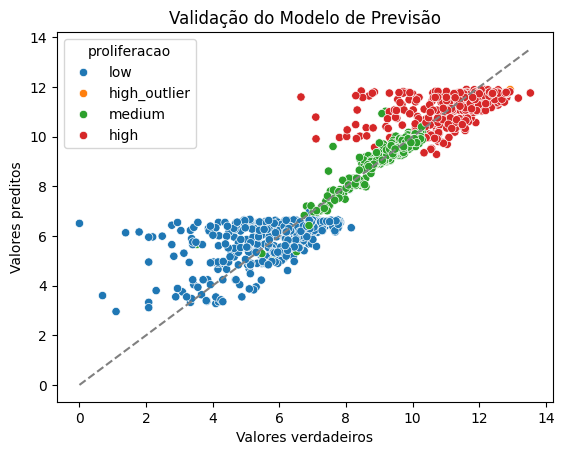

In [118]:
# Gráfico de dispersão com seaborn
sns.scatterplot(x=y_val, y=y_pred, hue=X_val.proliferacao)

# Adicionando linha de y = x (diagonal)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='gray')  # linha diagonal

# Configurações adicionais
plt.xlabel('Valores verdadeiros')
plt.ylabel('Valores preditos')
plt.title('Validação do Modelo de Previsão')

# Mostrar o gráfico
plt.show()

## 9. ERROR TRANSLATION AND INTERPRETATION

### 9.1. Business Performance

### 9.2. Total Performance

# VI. Implantação

## 10. DEPLOY MODEL PRODUCTION

### 10.1. Salvar modelo

In [ ]:
# Salvar o modelo 
with open('../models/model.pkl', 'wb') as file_model:
    pickle.dump(model_pipeline, file_model)

### 10.2. Salvar arquivo de submissão

In [121]:
# Fazer uma cópia do dataframe original
df_teste = df_teste_raw.copy()

# 0. Renomear colunas
df_teste.columns = rename_columns(df_teste.columns)

# 0. Remover duplicatas
df_teste = df_teste.drop_duplicates().reset_index(drop=True)
print('Quantidade de linhas após remover duplicatas: {:,}'.format(df_teste.shape[0]))
print('Quantidade de linhas após remover duplicatas: {:,}'.format(df_teste.shape[1]))

# Imprimir descrição dos dados antes da limpeza
print('*' *9 + ' Descrição dos dados | ANTES da limpeza ' + '*' *7)
data_description(df_teste)

# Limpar dataframe completo selected_columns
df_teste_cleaned, idx_nans = data_cleaning(df_teste[selected_columns], float_columns, int_columns, categorical_columns)
print(f'Limpar colunas selecionadas: {selected_columns}')

# Imprimir descrição dos dados antes da limpeza
print('*' *9 + ' Descrição dos dados | DEPOIS da limpeza ' + '*' *7)
data_description(df_teste_cleaned)

# Incluir features 
df_teste_featured = feature_engineering(df_teste_cleaned)

X_test = df_teste_featured.copy()

Quantidade de linhas após remover duplicatas: 1,500
Quantidade de linhas após remover duplicatas: 22
********* Descrição dos dados | ANTES da limpeza *******
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 1,500
Quantidade de colunas: 22

******************** DATA TYPES *************************
date                                           object
conscientizacao_da_populacao                    int64
condicoes_de_moradia_precarias                 object
falta_de_acesso_a_servicos_de_saude            object
migracao_de_pessoas_de_areas_endemicas         object
transporte_de_mercadorias_em_areas_urbanas     object
outros                                         object
presenca_do_mosquito                           object
casos_de_dengue                               float64
presenca_de_criadouros                         object
agua_parada_em_terrenos_baldios                object
presenca_de_piscinas_sem_manutencao            object
presenca_de_recipientes

In [122]:
X_test.shape

(1500, 24)

In [123]:
X_test.head()

,date,presenca_do_mosquito,conscientizacao_da_populacao,presenca_de_recipientes_sem_tampas,precipitacao,umidade,temperatura,condicoes_de_moradia_precarias,falta_de_acesso_a_servicos_de_saude,migracao_de_pessoas_de_areas_endemicas,...,presenca_de_piscinas_sem_manutencao,falta_de_coleta_de_lixo,areas_com_acumulo_de_entulhos,falta_de_controle_de_pragas,taxa_de_tratamento_de_esgoto,status,mes,semana_do_ano,proliferacao,outlier
0,2022-09-09,85338,1,58554,2.721541,69.471460,27.543774,0.386326,0.418609,0.450162,...,1768.0,0.148931,0.306590,0.203319,0.95,conscientizada,9,36,low,none
1,2019-11-23,61676,2,81346,19.603274,68.077958,25.353210,0.503462,0.457792,0.270386,...,3019.0,0.492292,0.697856,0.114251,0.95,parcialmente conscientizada,11,47,medium,none
2,2019-11-24,70395,2,74673,30.420928,60.885135,25.840312,0.454103,0.275503,0.572234,...,2195.0,0.382200,0.225819,0.275997,0.95,parcialmente conscientizada,11,47,medium,none
3,2019-11-25,455030,2,62218,52.309753,79.248920,27.450048,0.385898,0.363190,0.150847,...,549.0,0.062548,0.770299,0.097591,0.95,parcialmente conscientizada,11,48,medium,none
4,2019-11-26,137839,2,40665,25.596321,76.908404,29.141492,0.298810,0.419638,0.376613,...,1695.0,0.481431,0.369303,0.456221,0.95,parcialmente conscientizada,11,48,medium,none


In [124]:
# Aplicando o pipeline ao seu conjunto de dados X_test
df_teste_encoded = preprocessor.fit_transform(X_test)
df_teste_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cyclical__sin_mes__mes,cyclical__cos_mes__mes,cyclical__sin_semana__semana_do_ano,cyclical__cos_semana__semana_do_ano
0,0.084246,0.009062,0.537553,0.564074,-1.0,-1.836970e-16,-0.935016,-0.354605
1,0.060544,0.065424,0.512110,0.472651,-0.5,8.660254e-01,-0.568065,0.822984
2,0.069278,0.101540,0.380781,0.492980,-0.5,8.660254e-01,-0.568065,0.822984
3,0.454559,0.174618,0.716074,0.560163,-0.5,8.660254e-01,-0.464723,0.885456
4,0.136835,0.085432,0.673340,0.630755,-0.5,8.660254e-01,-0.464723,0.885456


In [125]:
df_teste_encoded.shape

(1500, 8)

In [126]:
y_hat_test = model_pipeline.predict(X_test)
final_test = pd.concat([X_test, pd.Series(np.expm1(y_hat_test), name='Casos de dengue')], axis=1)
final_test = final_test[['date', 'Casos de dengue']].sort_values('date')
final_test.shape
final_test

,date,Casos de dengue
1,2019-11-23,2603.302779
2,2019-11-24,2931.654165
3,2019-11-25,20482.094467
4,2019-11-26,7610.739793
5,2019-11-27,17216.874534
...,...,...
1495,2023-12-27,63498.028484
1496,2023-12-28,96680.685238
1497,2023-12-29,30697.849864
1498,2023-12-30,48319.091610


In [127]:
# Exportar o arquivo
final_test.to_csv('../data/submission/submission_file_02.csv', index=False)

### 10.3. Prever resultados do teste

In [ ]:

# Consertar as referencias das features no item 5 e 8
# Colocar todo o processo dentro do pipeline
# Fazer o streamlit
# Fazer a apresentação
# Fazer a outra parte do outliers: analisar e remover os outliers de casos de dengue